In [ ]:
from skimage import io
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth, AgglomerativeClustering
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from os import listdir
from os.path import isfile, join
from google.colab import drive
drive.mount('/content/drive/')
import pickle
import math
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive/


In [ ]:
# param: image (string)
# takes the image name (and location) as an input

# output: tuple
# tuple[0] = scale (and noise)
# tuple[1] = preprocessed image

def preprocess_image(image_name, med_blur):
  img = cv2.imread(image_name)
  color_im_2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  color_im_3 = cv2.cvtColor(color_im_2, cv2.COLOR_RGB2HSV)

  ## Show original image
  # plt.figure()
  # plt.imshow(color_im_2)
  # plt.title('Original Image')

  # Make numpy versions
  RGBna = np.array(color_im_2)
  HSVna = np.array(color_im_3)

  # Extract Hue
  H = HSVna[:,:,0]
  # Extract Value
  V = HSVna[:,:,2]

  # Find all pink pixels, i.e. where 180 < Hue < 340
  lo,hi = -20, 180
  # Rescale to 0-255, rather than 0-360 because we are using uint8
  lo = int((lo * 255) / 360)
  hi = int((hi * 255) / 360)
  notPink = np.where((H>lo) & (H<hi))

  notDark = np.where(V > 30)

  # Make all notPink pixels white in original image
  RGBna[notPink] = [255,255,255]

  gray_im_4 = cv2.cvtColor(RGBna, cv2.COLOR_RGB2GRAY)
  
  # gamma correction, blur, adaptive threshold, median blur
  gray_correct_2 = np.array(255 * (gray_im_4 / 255) ** 3.7 , dtype='uint8')
  blur = cv2.GaussianBlur(gray_correct_2,(17,17),1)
  ## Show Gaussian Blur
  # plt.figure()
  # plt.imshow(blur, cmap="gray")
  # plt.title('Gaussian Blur Applied To Grayscale')

  thresh = cv2.adaptiveThreshold(blur, 7050, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 111, 2)
  thresh = cv2.bitwise_not(thresh)
  ## Show Adaptive Threshold
  # plt.figure()
  # plt.imshow(thresh, cmap="gray")
  # plt.title('Adaptive Threshold Applied')

  median = cv2.medianBlur(thresh, med_blur)
  # plt.figure()
  # plt.imshow(median, cmap="gray")
  # plt.title('Median Filter Applied')

  return median


In [ ]:
def extract_scale(img_name): ##if the height not in range +- 205 and 102 then search through array to find one in the height, if not print out name of message of picture
  img = cv2.imread(img_name)
  color_im_2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  color_im_3 = cv2.cvtColor(color_im_2, cv2.COLOR_RGB2HSV)
  RGBna2 = np.array(color_im_2)

  HSVna = np.array(color_im_3)
  V = HSVna[:,:,2]
  notDark = np.where(V > 7)
  RGBna2[notDark] = [255,255,255]

  scale_shown = cv2.cvtColor(RGBna2, cv2.COLOR_RGB2GRAY)

  scale_shown = np.array(255 * (scale_shown / 255) ** 3.7 , dtype='uint8')
  scale_shown = cv2.medianBlur(scale_shown, 11)
  scale_shown = cv2.bitwise_not(scale_shown)  ## invert black and white

  # plt.figure()
  # plt.imshow(scale_shown, cmap="gray")
  # plt.title('SCALE FUNCTION')

  output = cv2.connectedComponentsWithStats(scale_shown)
  num_labels = output[0]
  labels = output[1]
  stats = output[2]

  heights = []
  for i in range(num_labels):
    heights.append(stats[i, cv2.CC_STAT_HEIGHT])
  heights.sort()

  ## The scale will be the second tallest connected component (tallest being the whole background)
  scale_height = None
  for height in heights:
    if ((height >= 98 and height <= 105) or((height >= 202 and height <= 208))):
      scale_height = height  

  if scale_height == None:
    scale_height = 102

  ## Plot connected Components
  label_hue = np.uint8(179 * labels / np.max(labels))
  blank_ch = 255 * np.ones_like(label_hue)
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
  labeled_img[label_hue == 0] = 0

  plt.figure()
  plt.title('Scale Connect Components with Scale Height ' + str(scale_height))
  plt.imshow(labeled_img)
  plt.show()

  return scale_height

In [ ]:
def initial_connected_components(median_img):
  ret, labels = cv2.connectedComponents(median_img)
  label_hue = np.uint8(179 * labels / np.max(labels))
  blank_ch = 255 * np.ones_like(label_hue)
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
  labeled_img[label_hue == 0] = 0

  # plt.figure()
  # plt.title('Objects counted:'+ str(ret-1))
  # plt.imshow(labeled_img)
  # plt.show()

In [ ]:
## Store the width, height, and area of each vessel element
## Used this post to help (https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python)
def extract_data(blur_img, pxl_to_micro):
  output = cv2.connectedComponentsWithStats(blur_img)
  num_labels = output[0]
  labels = output[1]
  stats = output[2]
  centroids = output[3]  ## Maybe the centroids will be useful?

  vessels = []
  for i in range(num_labels):
    width = stats[i, cv2.CC_STAT_WIDTH] * pxl_to_micro
    height = stats[i, cv2.CC_STAT_HEIGHT] * pxl_to_micro
    area =  stats[i, cv2.CC_STAT_AREA] * pxl_to_micro
    left_start = stats[i, cv2.CC_STAT_LEFT]
    top_start = stats[i, cv2.CC_STAT_TOP]
    if (height > width):
      major_axis = height/2
      minor_axis = width/2
      center = (minor_axis,major_axis)
      foci_distance = math.sqrt(major_axis**2 - minor_axis**2)
      eccentricity = foci_distance / major_axis 
      # print(eccentricity)
      # foci_1 = (minor_axis,major_axis + foci_distance)
      # foci_2 = (minor_axis,major_axis - foci_distance)
    elif (width > height):
      major_axis = width/2
      minor_axis = height/2
      center = (major_axis,minor_axis)
      foci_distance = math.sqrt(major_axis**2 - minor_axis**2)
      eccentricity = foci_distance / major_axis 
      # print(eccentricity)

      # foci_1 = (major_axis + foci_distance,minor_axis)
      # foci_2 = (major_axis - foci_distance,minor_axis)
    else: 
      eccentricity = 0 

    vessels.append([width, height, area, left_start, top_start, eccentricity])

  vessel_df = pd.DataFrame(vessels, columns=['width', 'height', 'area', 'left_start_pxl', 'top_start_pxl','eccentricity'])
  
  return (vessel_df, labels)


## Perform outlier detection on both pixel location and pixel size of detected objects to remove the detected objects that aren't vessel elements
def drop_extras(vessel_df, min_area, max_area):
  outliers_indices = vessel_df.loc[(vessel_df['area'] > max_area) | (vessel_df['area'] < min_area) | (vessel_df['eccentricity'] > 0.90 )].index.tolist()
  print("Num outliers", len(outliers_indices))
  vessel_df = vessel_df.drop(outliers_indices, 0).reset_index(drop=True)
  print("Num objs left", len(vessel_df['area']))

  return vessel_df, outliers_indices


## Note: this function may take a bit of time to run
def remove_extras_image(labels, outliers_indices):
  ## Remove outliers from labels img by giving them the "1" label
  for outlier in outliers_indices:
    labels[labels == outlier] = 1
    
  ## Display the non-outliers
  label_hue = np.uint8(179 * labels / np.max(labels))
  blank_ch = 255 * np.ones_like(label_hue)
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
  labeled_img[label_hue == 0] = 0

  plt.figure()
  plt.imshow(labeled_img)
  plt.title("Vessel Elements")


In [ ]:
## Function to calculate vessel density, by making a rectangle that
## encompasses all the vessels within
def calc_v_density(img_df, pxl_to_milli):
  left_start_col = img_df['left_start_pxl']
  top_start_col = img_df['top_start_pxl']

  rect_x = img_df['left_start_pxl'].min()
  rect_y = img_df['top_start_pxl'].min()

  rect_bottom_x = img_df['left_start_pxl'].max()
  rect_bottom_y = img_df['top_start_pxl'].max()

  # find the associated vessels with rect_bottom_x & rect_bottom_x
  max_index_left = left_start_col.idxmax()
  max_index_bottom = top_start_col.idxmax()

  rect_w = (rect_bottom_x + img_df['width'][max_index_left]*pxl_to_milli*1000) - rect_x
  rect_h = (rect_bottom_y + img_df['height'][max_index_bottom]*pxl_to_milli*1000) - rect_y

  # rect_area in mm^2
  rect_area = (rect_w * pxl_to_milli) * (rect_h * pxl_to_milli)
  img_df['vessel_density'] = img_df.shape[0] / rect_area
  calc_v_vulnerability_i(img_df)
  return img_df

## Function to calculate vessel vulnerability index
def calc_v_vulnerability_i(img_df):
  v_i = []
  for i in range(img_df.shape[0]):
    vessel_w = img_df['width'][i]
    vessel_h = img_df['height'][i]
    diameter = 0
    if (vessel_w > vessel_h):
      diameter = vessel_w * 2
    else:
      diameter = vessel_h * 2
    v_i.append(diameter / img_df['vessel_density'][i])
  img_df['vessel_vulnerability_index'] = v_i

In [ ]:
## agglomerated clustering for automatic cluster detection of vessels

## sources:
## https://www.datanovia.com/en/lessons/agglomerative-hierarchical-clustering/
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
def detect_vessel_clustering(img_df):
  vessel_coor = img_df[['left_start_pxl', 'top_start_pxl']].copy()
  clustering = AgglomerativeClustering(distance_threshold = 70, n_clusters = None, compute_full_tree = True, linkage = 'single')
  c = clustering.fit_predict(vessel_coor)

  img_df['group_name'] = c
  calc_v_grouping_indices(img_df)

## calculating the vessel grouping indices
def calc_v_grouping_indices(img_df):
  num_vessels = img_df.shape[0]
  num_groupings = get_num_groups(img_df)
  num_solitary_vessels = num_vessels - num_groupings

  if (num_groupings != 0):
    v_g = num_vessels / num_groupings
    v_s = num_solitary_vessels / num_groupings
  else:
    v_g = 0
    v_s = 0

  f_vm = num_groupings / num_vessels
  img_df['vessel_grouping_index'] = v_g
  img_df['solitary_vessel_index'] = v_s
  img_df['vessel_multiple_fraction'] = f_vm

## Helper function for finding the number of vessel clusters
def get_num_groups(img_df):
  s = img_df['group_name'].value_counts()
  s = s[s>1]
  return len(s)

## Helper function for plotting the autogenerated clusters
## returns df of just the groups
def plot_just_groups(img_df):
  img_df_2 = img_df.copy()
  s = img_df_2['group_name'].value_counts()
  s = s[s>1]

  img_df_2 = img_df_2[img_df_2['group_name'].isin(s.index)]
  plt.figure() 
  scatter = plt.scatter(img_df_2['left_start_pxl'], img_df_2['top_start_pxl'],  
              c = img_df_2['group_name'], cmap ='rainbow') 
  plt.title('group location')
  ax = scatter.axes
  ax.invert_yaxis()
  plt.show(scatter)
  return img_df_2


In [ ]:
## Driver function of the entire image analysis process
def analyze_img(img_name, med_blur, min_area, max_area):
  median_img = preprocess_image(img_name, med_blur)

  scale_height = extract_scale(img_name)
  ## Convert pixels to micrometers
  pxl_to_micro = scale_height / 100
  ## Convert pixels to millimeters
  pxl_to_milli = pxl_to_micro / 1000

  ## Show initial connected components
  initial_connected_components(median_img)

  ## Extract data from image and put into Dataframe
  data = extract_data(median_img, pxl_to_micro)
  vessel_df = data[0]
  labels = data[1]
  
  ## Drop the extra detected connected components
  data = drop_extras(vessel_df, min_area, max_area)
  vessel_df = data[0]
  outlier_indices = data[1]

  ## Show the connected components with outliers removed
  remove_extras_image(labels, outlier_indices)

  ## Adding vessel info
  calc_v_density(vessel_df, pxl_to_milli)
  detect_vessel_clustering(vessel_df)
  plot_just_groups(vessel_df)

  print("Total elements:", len(vessel_df))
  
  return vessel_df

## Set blurs

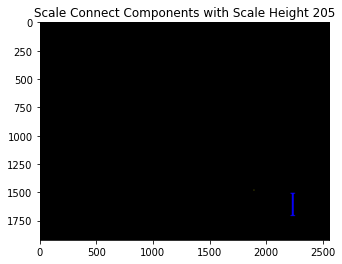

Num outliers 460
Num objs left 213


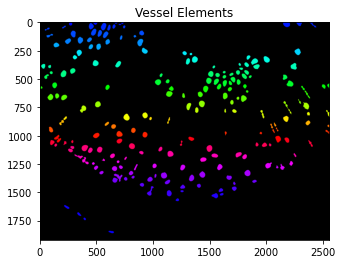

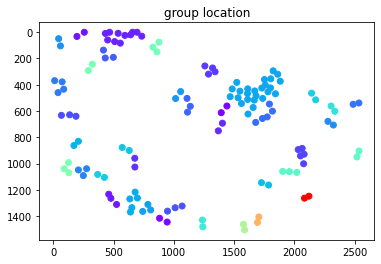

Total elements: 213


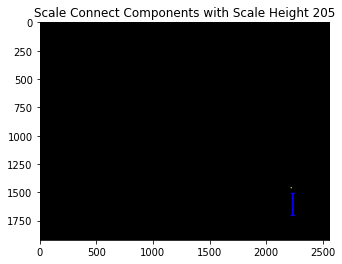

Num outliers 250
Num objs left 191


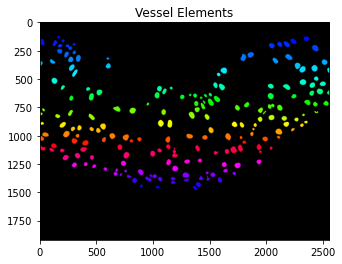

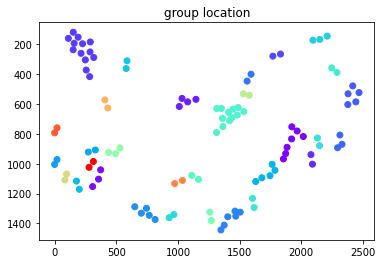

Total elements: 191


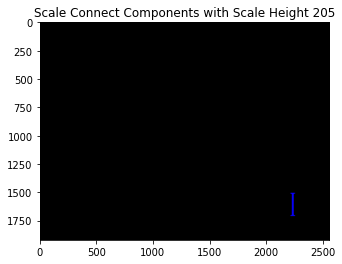

Num outliers 331
Num objs left 222


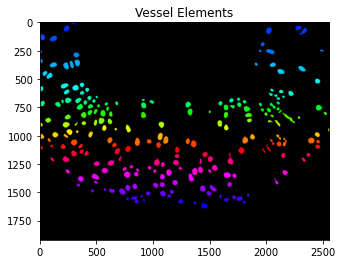

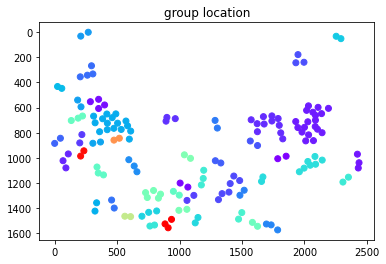

Total elements: 222


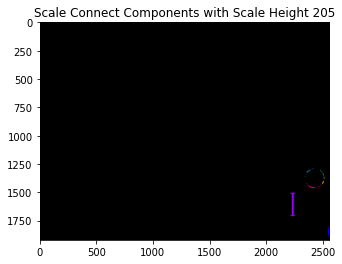

Num outliers 135
Num objs left 230


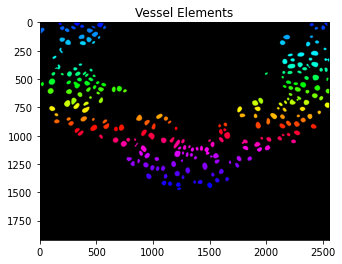

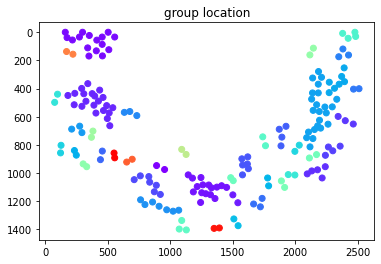

Total elements: 230


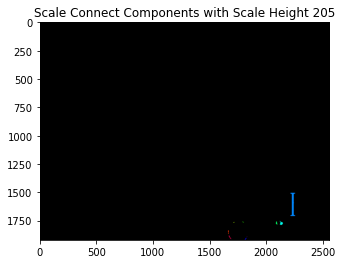

Num outliers 149
Num objs left 229


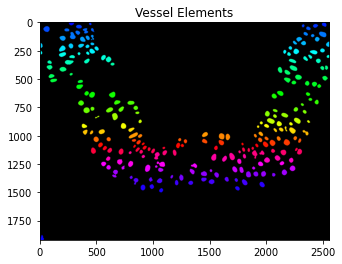

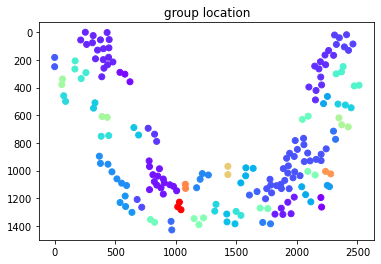

Total elements: 229


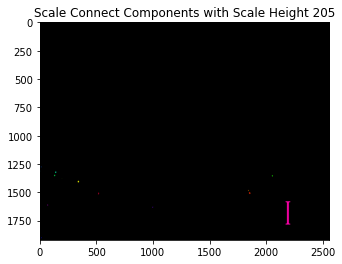

Num outliers 346
Num objs left 247


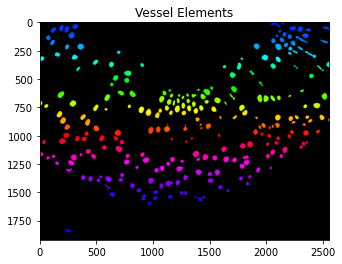

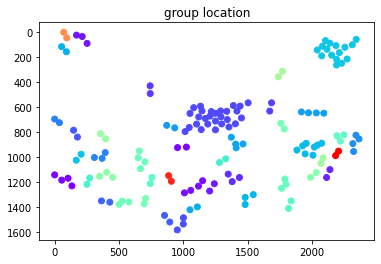

Total elements: 247


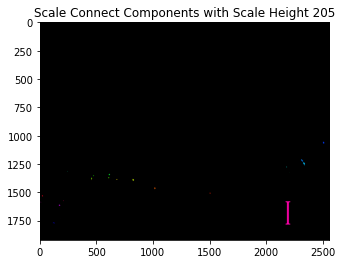

Num outliers 327
Num objs left 237


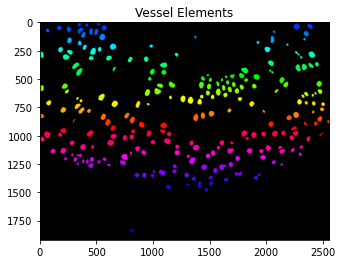

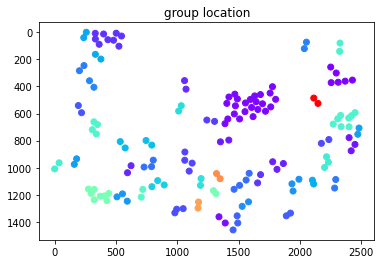

Total elements: 237


KeyboardInterrupt: ignored

In [ ]:
## Automated Image Processing  (Make sure you mounted drive in first code block)
images = listdir('/content/drive/Shareddrives/WoodImages/WoodImagesAll/')
img_directory = ['/content/drive/Shareddrives/WoodImages/WoodImagesAll/' + img for img in images]
all_images = []


def process_all():
  for img in img_directory:
    med_blur = 21
    min_area = 650
    max_area = 5000
    img_df = analyze_img(img, med_blur, min_area, max_area)

    ## Can do the clustering of images thing here

    name_parts = img.split('/')[-1].split('_')[0:3]
    img_id = '_'.join(name_parts) ## this is the first three things in the image name that correspond to the ID column in the data Groover sent us

    phenotype = img_id.split('_')[-1]
    img_df['phenotype'] = phenotype
    all_images.append({ 'df': img_df, 'id': img_id })  ## can add more properties to the object later if we need
 
process_all()

## Write all_images to a file for easy import later
with open("all_images.txt", "wb") as fp:
  pickle.dump(all_images, fp)


# After removing


In [ ]:
all_images = []
## Read the image data
with open("/content/drive/Shareddrives/WoodImages/WoodImagesData/all_images.txt", "rb") as fp:   # Unpickling
  all_images = pickle.load(fp)

In [ ]:
## Clustering of images algorithm
img_ids = []
for img in all_images:
  img_ids.append(img['id'])

colors = {
    0: '#ff009d', # light blue
    1: '#47e549', # kelly green
    2: '#ffc854',
    3: '#ffe500', # bright yellow
    4: '#00f6ff', # aqua blue
    5: '#f200ff', # purple
    6: '#ff9d00', # orange
    7: '#3300ff', # dark blue
    8: '#ff0000', # red
    9: '#ffbff1', # light pink
    10: '#d5ffc9', # light green
    11: '#511919', # dark redish brown
    12: '#fbfccc', # pale yellow
    13: '#ad7579', # gray purple
    14: '#2b2556', # navy blue
    15: '#000000', # black
    16: '#3f3a3a', # dark gray
    17: '#777777', # lighter gray
    18: '#cecccc', # really light gray
    19: '#efc986', # light tan
    20: '#ffc854', # light orange
}


feature_combinations = [['area', 'top_start_pxl'], ['area', 'eccentricity'], ['area', 'phenotype'], ['eccentricity', 'phenotype'], ['vessel_density', 'area'], ['eccentricity', 'vessel_vulnerability_index'], ['vessel_density', 'phenotype']]

for combo in feature_combinations:
  combo_data = []
  all_phenos = []
  for img in all_images:
    # Store mean areas average area
    img_df = img['df']
    combo_data.append([img_df[combo[0]].median(), img_df[combo[1]].median()])
    all_phenos.append(int(img_df['phenotype'][0]))


  # Build the Mean Areas + Number Vesssel Elements MeanShift model
  # These articles helped us understand how to use MeanShift with sklearn 
  #(https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html)
  #(https://www.machinecurve.com/index.php/2020/04/23/how-to-perform-mean-shift-clustering-with-python-in-scikit/)
  X = pd.DataFrame(combo_data, columns=[combo[0], combo[1]], index=img_ids)


  bandwidth = estimate_bandwidth(X, quantile=0.3, n_samples=len(X)) ## Look into the arguments more closely later
  cluster_model = MeanShift(bandwidth=bandwidth).fit(X)
  cluster_labels = cluster_model.labels_
  cluster_centers = cluster_model.cluster_centers_
  cluster_predictions = cluster_model.predict(X)

  ## Plot the clusters

  cluster_colors = [colors[pred] for pred in cluster_predictions]
  #cluster_colors = all_phenos
  plt.figure()
  plt.scatter(X[combo[0]], X[combo[1]], c=cluster_colors, marker="o", picker=True)
  plt.xlabel(combo[0])
  plt.ylabel(combo[1])
  plt.title("median " + combo[0] + ' vs ' + "median " + combo[1])


## Do clusters based on total vessel elements
features = ['width', 'height', 'area', 'left_start_pxl', 'top_start_pxl','eccentricity', 'phenotype']
for feature in features:
  feature_num = []
  for img in all_images:
    # Store mean areas average area
    img_df = img['df']
    feature_num.append([img_df[feature].median(), len(img_df[feature])])


  # Build the Mean Areas + Number Vesssel Elements MeanShift model
  # These articles helped us understand how to use MeanShift with sklearn 
  #(https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html)
  #(https://www.machinecurve.com/index.php/2020/04/23/how-to-perform-mean-shift-clustering-with-python-in-scikit/)
  X = pd.DataFrame(feature_num, columns=[feature, 'num_vessels'], index=img_ids)


  bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=len(X)) ## Look into the arguments more closely later
  cluster_model = MeanShift(bandwidth=bandwidth).fit(X)
  cluster_labels = cluster_model.labels_
  cluster_centers = cluster_model.cluster_centers_
  cluster_predictions = cluster_model.predict(X)

  ## Plot the clusters

  cluster_colors = [colors[pred] for pred in cluster_predictions]
  plt.figure()
  plt.scatter(X[feature], X['num_vessels'], c=cluster_colors, marker="o", picker=True)
  plt.xlabel(feature)
  plt.ylabel('num_vessels')
  plt.title("median " + feature + ' vs number vessel elements')

# Extra Data Analysis

VIFs: {'height_y1': 50.609792175884735, 'dbase_y1': 70.0307439474382, 'dbh_y1': 69.12723609398361, 'height_y2': 46.62582300061298, 'dbase_y2': 117.74267002048825, 'dbh_y2': 91.71512652453696}


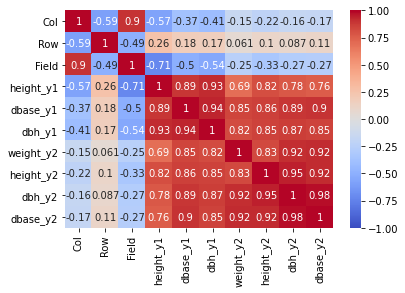

In [ ]:
yr2_df = pd.read_csv('/content/drive/Shareddrives/WoodImages/WoodImagesData/year2.txt', sep="\t")
biodata_df = pd.read_csv('/content/drive/Shareddrives/WoodImages/WoodImagesData/year1.txt', sep="\t")


biodata_df['weight_y2'] = yr2_df['weight_y2']
biodata_df['height_y2'] = yr2_df['height_y2']
biodata_df['dbh_y2'] = yr2_df['dbh_y2']
biodata_df['dbase_y2'] = yr2_df['dbase_y2']

## Drop all rows with at least one NaN value. Maybe do data interpolation later
biodata_df = biodata_df.dropna()


## Keep the data that correspond to an image we processed based on their IDs
#img_ids = all_images.keys()
#biodata_df = biodata_df.loc[biodata_df['ID'] in img_ids]


sns.heatmap(biodata_df.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

X_cols = ['height_y1', 'dbase_y1', 'dbh_y1', 'height_y2', 'dbase_y2', 'dbh_y2']

X = biodata_df[X_cols]

## Drop the features from X with high VIFs
# X = X.drop('dbase_y2', 1)
# X = X.drop('dbh_y1', 1)
# X = X.drop('dbase_y1', 1)
# X = X.drop('height_y2', 1)


vifs = {name: variance_inflation_factor(X.values, i) for name, i in zip(X.columns, range(X.shape[1]))}
print("VIFs:", vifs)



## Develop an Artificial Neural Network



# Regression Models



Using Dr. Groover Data Set - Logisitic

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

yr2_df = pd.read_csv('/content/drive/Shareddrives/WoodImages/WoodImagesData/year2.txt', sep="\t")
biodata_df = pd.read_csv('/content/drive/Shareddrives/WoodImages/WoodImagesData/year1.txt', sep="\t")


biodata_df['weight_y2'] = yr2_df['weight_y2']
biodata_df['height_y2'] = yr2_df['height_y2']
biodata_df['dbh_y2'] = yr2_df['dbh_y2']
biodata_df['dbase_y2'] = yr2_df['dbase_y2']

## Drop all rows with at least one NaN value. Maybe do data interpolation later
biodata_df = biodata_df.dropna()
# Checks to see if sample has gray irradiation. 100 means yes, 0 means no. E.g. XXX_100_16_5 yes, IFG_0_59_4 no.
biodata_df['gray_irradiation'] = biodata_df.ID.str.contains(r'_100_')
# Label Encoding for Categorical 
biodata_df['gray_irradiation'] = biodata_df['gray_irradiation'].astype('category').cat.codes

# Limits to GWR ID only
biodata_df = biodata_df[biodata_df["ID"].str.contains('GWR')]

# Getting rid of ID with letter in 'part 2'
biodata_df = biodata_df[~biodata_df.ID.str.contains("217A")]
biodata_df['phenotype'] = biodata_df.ID.str.split('_').str[2]
print(biodata_df)


X = biodata_df[['height_y1', 'dbase_y1', 'dbh_y1', 'height_y2', 'dbase_y2', 'dbh_y2', 'gray_irradiation', 'Field']]
Y = biodata_df[['phenotype']]

X = stats.zscore(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegression(solver='sag', max_iter = 1000)
model.fit(X_train,y_train)
print('Done Training')

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict = True)
pd.DataFrame(report).transpose()


         Old.Name             ID  Col  ...  dbase_y2 gray_irradiation  phenotype
73    GWR_100_157  GWR_100_157_6    2  ...     48.99                1        157
75    GWR_100_220  GWR_100_220_5    2  ...    104.59                1        220
81    GWR_100_199  GWR_100_199_3    2  ...     46.07                1        199
85    GWR_100_231  GWR_100_231_4    2  ...     57.48                1        231
89    GWR_100_343  GWR_100_343_2    2  ...     18.48                1        343
...           ...            ...  ...  ...       ...              ...        ...
2601  GWR_100_233    GWR_100_233   47  ...     14.04                1        233
2604   GWR_100_66     GWR_100_66   47  ...     44.78                1         66
2605  GWR_100_402    GWR_100_402   47  ...     31.03                1        402
2607  GWR_100_234    GWR_100_234   47  ...     60.63                1        234
2608  GWR_100_389    GWR_100_389   47  ...     81.13                1        389

[856 rows x 15 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Done Training


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,1.000000
104,0.000000,0.000000,0.000000,1.000000
105,0.000000,0.000000,0.000000,1.000000
107,0.000000,0.000000,0.000000,2.000000
110,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000
99,0.000000,0.000000,0.000000,1.000000
accuracy,0.005814,0.005814,0.005814,0.005814
macro avg,0.005495,0.005495,0.005495,172.000000


Using Our Processing Image Data Set

In [ ]:
appended_data = []
for img in all_images:
  appended_data.append(img['df'])

appended_data = pd.concat(appended_data)


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = appended_data[['width', 'height', 'area', 'left_start_pxl', 'top_start_pxl', 'eccentricity', 'vessel_density', 'vessel_vulnerability_index', 'group_name', 'vessel_grouping_index', 'solitary_vessel_index',	'vessel_multiple_fraction']]
Y = appended_data[['phenotype']]

print(X)
print(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=0)

clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on testing set: {:.2f}'.format(clf.score(X_test, y_test)))

      width  height  ...  solitary_vessel_index  vessel_multiple_fraction
0    110.70  108.65  ...               4.605263                  0.178404
1     59.45   63.55  ...               4.605263                  0.178404
2     88.15   51.25  ...               4.605263                  0.178404
3     57.40   32.80  ...               4.605263                  0.178404
4     94.30   57.40  ...               4.605263                  0.178404
..      ...     ...  ...                    ...                       ...
96    94.30  110.70  ...               4.315789                  0.188119
97    63.55   47.15  ...               4.315789                  0.188119
98    82.00   69.70  ...               4.315789                  0.188119
99    51.25   59.45  ...               4.315789                  0.188119
100   73.80   75.85  ...               4.315789                  0.188119

[155841 rows x 12 columns]
    phenotype
0          30
1          30
2          30
3          30
4          30


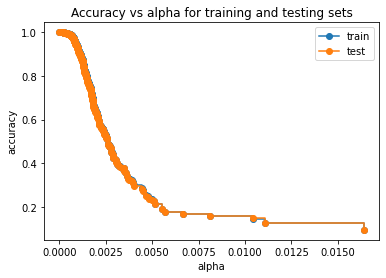

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(ccp_alpha=0.003)
clf.fit(X_train, y_train)


print('Accuracy of Decision Tree classifier on testing set: {:.2f}'.format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))

%matplotlib inline
from sklearn.tree import plot_tree
plt.subplots(figsize=(100, 100))
plot_tree(clf,filled=True, fontsize=15)
plt.show()

Logisitic

In [ ]:
import scipy.stats as stats

X = appended_data[['width', 'height', 'area', 'left_start_pxl', 'top_start_pxl', 'eccentricity', 'vessel_density', 'vessel_vulnerability_index', 'group_name', 'vessel_grouping_index', 'solitary_vessel_index',	'vessel_multiple_fraction']]
Y = appended_data[['phenotype']]

X = stats.zscore(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='sag')
model.fit(X_train,y_train)
print('Done Training')

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict = True)
pd.DataFrame(report).transpose()